#  Анализ и интерпретация результатов работы нейросетевых моделей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://github.com/TylerYep/torchinfo
* https://docs.pytorch.org/tutorials/intermediate/visualizing_gradients_tutorial.html
* https://github.com/johnmarktaylor91/torchlens
* https://captum.ai/docs/extension/integrated_gradients
* https://captum.ai/tutorials/House_Prices_Regression_Interpret
* https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
* https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html


## Задачи для совместного разбора

1\. Обсудите проблему анализа и интерпретации работы нейросетевых моделей. Рассмотрите готовые решения для этих задач.

## Задачи для самостоятельного решения

In [30]:
import pandas as pd
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torchlens as tl
import matplotlib.pyplot as plt
import warnings
import torch.optim as optim
from tqdm import tqdm
from captum.attr import IntegratedGradients
import seaborn as sns
import shap
import numpy as np
from IPython.display import HTML
warnings.filterwarnings("ignore", category=UserWarning, module='torchlens')

<p class="task" id="1"></p>

1\. На основе файла `synthetic_coffee_health_10000.csv` создайте набор данных в смысле `torch.utils.data.Dataset`. Закодируйте все нечисловые переменные при помощи `LabelEncoder`. Целевая переменная - столбец `Health_Issues`. Разделите датасет на обучающее и тестовое множество.

- [ ] Проверено на семинаре

In [31]:
class CoffeeHealthDataset(Dataset):
    """
    Класс для работы с датасетом о влиянии кофе на здоровье.
    Выполняет загрузку, кодирование категориальных признаков и
    предоставляет доступ к данным в формате тензоров PyTorch.
    """
    def __init__(self, csv_path: str):
        """
        Инициализация датасета.

        Args:
            csv_path (str): Путь к CSV файлу с данными.
        """
        try:
            self.df = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"Ошибка: Файл {csv_path} не найден.")
            # Создаем пустой DataFrame, чтобы избежать дальнейших ошибок при инициализации
            self.df = pd.DataFrame()
            self.features = torch.empty(0)
            self.target = torch.empty(0)
            return
        
        self.df = self.df.drop('ID',axis=1)

        self._preprocess_data()

        # Отделяем признаки от целевой переменной
        features_df = self.df.drop('Health_Issues', axis=1)
        target_series = self.df['Health_Issues']

        # Конвертируем в тензоры PyTorch
        self.features = torch.tensor(features_df.values, dtype=torch.float32)
        self.target = torch.tensor(target_series.values, dtype=torch.long)
        self.feature_names = features_df.columns.tolist()


    def _preprocess_data(self):
        """
        Выполняет кодирование нечисловых признаков с помощью LabelEncoder.
        """
        for col in self.df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col])

    def __len__(self):
        """
        Возвращает общее количество сэмплов в датасете.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Возвращает один сэмпл (признаки и цель) по указанному индексу.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.features[idx], self.target[idx]

    def get_splits(self, test_size=0.2, random_state=42):
        """
        Разделяет датасет на обучающую и тестовую выборки.

        Args:
            test_size (float): Доля тестовой выборки (от 0 до 1).
            random_state (int): Сид для воспроизводимости разделения.

        Returns:
            A tuple of (train_dataset, test_dataset)
        """
        if len(self) == 0:
            return None, None

        indices = list(range(len(self)))

        # Используем stratify для сохранения распределения классов в выборках
        train_indices, test_indices = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=self.target.numpy()
        )

        train_dataset = torch.utils.data.Subset(self, train_indices)
        test_dataset = torch.utils.data.Subset(self, test_indices)

        return train_dataset, test_dataset

In [32]:
FILE_PATH = 'synthetic_coffee_health_10000.csv'

full_dataset = CoffeeHealthDataset(FILE_PATH)


train_data, test_data = full_dataset.get_splits(test_size=0.2)

print(f"Общий размер датасета: {len(full_dataset)}")
print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print("-" * 30)

features, target = train_data[0]
print("Пример данных из обучающей выборки:")
print(f"Признаки (тип: {features.dtype}, форма: {features.shape}):\n{features}")
print(f"Целевая переменная (тип: {target.dtype}, форма: {target.shape}): {target}")
print("-" * 30)
print(f"Названия признаков:")
print(*full_dataset.feature_names, sep='\n')

Общий размер датасета: 10000
Размер обучающей выборки: 8000
Размер тестовой выборки: 2000
------------------------------
Пример данных из обучающей выборки:
Признаки (тип: torch.float32, форма: torch.Size([14])):
tensor([ 38.0000,   0.0000,   5.0000,   2.3000, 219.4000,   8.8000,   0.0000,
         21.9000,  80.0000,   1.0000,   6.7000,   2.0000,   0.0000,   0.0000])
Целевая переменная (тип: torch.int64, форма: torch.Size([])): 3
------------------------------
Названия признаков:
Age
Gender
Country
Coffee_Intake
Caffeine_mg
Sleep_Hours
Sleep_Quality
BMI
Heart_Rate
Stress_Level
Physical_Activity_Hours
Occupation
Smoking
Alcohol_Consumption


<p class="task" id="2"></p>

2\. Опишите нейросетевую модель, имеющую следующую структуру:

```
NestedSequentialModel(
  (layer1): Sequential(
    (0): Linear
    (1): ReLU
    (2): Linear
    (3): ReLU
  )
  (layer2): Sequential(
    (0): Linear
    (1): ReLU
    (2): Linear
  )
)
```
Используя пакет `torchinfo`, выведите на экран основную информацию о данной модели: количество и размер слоев, размеры промежуточных выходов, занимаемую память и т.д.


- [ ] Проверено на семинаре

In [33]:
class NestedSequentialModel(nn.Module):
    """
    Нейросетевая модель с вложенной структурой Sequential-слоев,
    согласно заданию.
    """
    def __init__(self, input_features=11, num_classes=2):
        """
        Инициализация модели.

        Args:
            input_features (int): Количество входных признаков.
            num_classes (int): Количество выходных классов.
        """
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        """
        Прямой проход данных через модель.
        """
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [34]:
INPUT_FEATURES = len(full_dataset.feature_names)
BATCH_SIZE = 16

model = NestedSequentialModel(input_features=INPUT_FEATURES)

summary(model, input_size=(BATCH_SIZE, INPUT_FEATURES))

Layer (type:depth-idx)                   Output Shape              Param #
NestedSequentialModel                    [16, 2]                   --
├─Sequential: 1-1                        [16, 32]                  --
│    └─Linear: 2-1                       [16, 64]                  960
│    └─ReLU: 2-2                         [16, 64]                  --
│    └─Linear: 2-3                       [16, 32]                  2,080
│    └─ReLU: 2-4                         [16, 32]                  --
├─Sequential: 1-2                        [16, 2]                   --
│    └─Linear: 2-5                       [16, 16]                  528
│    └─ReLU: 2-6                         [16, 16]                  --
│    └─Linear: 2-7                       [16, 2]                   34
Total params: 3,602
Trainable params: 3,602
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.

<p class="task" id="3"></p>

3\. Выберите один батч размера 16 из созданного датасета. Используя пакет `torchlens`:
* визуализируйте структуру модели
* получите результаты всех промежуточных вычислений
* получите градиенты по всем слоям модели (используйте любую функцию потерь, адекватную для данной задачи)
* визуализируйте для каждого слоя модели среднее из абсолютных значений координат тензора градиента.



- [ ] Проверено на семинаре

Структура модели


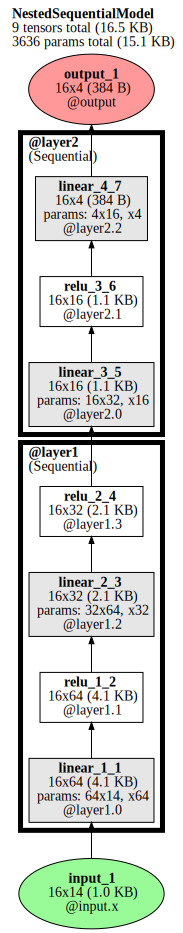



 Промежуточные вычисления
Выход слоя 'input_1': torch.Size([16, 14])
Выход слоя 'linear_1_1': torch.Size([16, 64])
Выход слоя 'relu_1_2': torch.Size([16, 64])
Выход слоя 'linear_2_3': torch.Size([16, 32])
Выход слоя 'relu_2_4': torch.Size([16, 32])
Выход слоя 'linear_3_5': torch.Size([16, 16])
Выход слоя 'relu_3_6': torch.Size([16, 16])
Выход слоя 'linear_4_7': torch.Size([16, 4])
Выход слоя 'output_1': torch.Size([16, 4])


 Градиенты
Градиент для 'input_1': None
Градиент для 'linear_1_1': torch.Size([16, 64])
Градиент для 'relu_1_2': torch.Size([16, 64])
Градиент для 'linear_2_3': torch.Size([16, 32])
Градиент для 'relu_2_4': torch.Size([16, 32])
Градиент для 'linear_3_5': torch.Size([16, 16])
Градиент для 'relu_3_6': torch.Size([16, 16])
Градиент для 'linear_4_7': torch.Size([16, 4])
Градиент для 'output_1': torch.Size([16, 4])





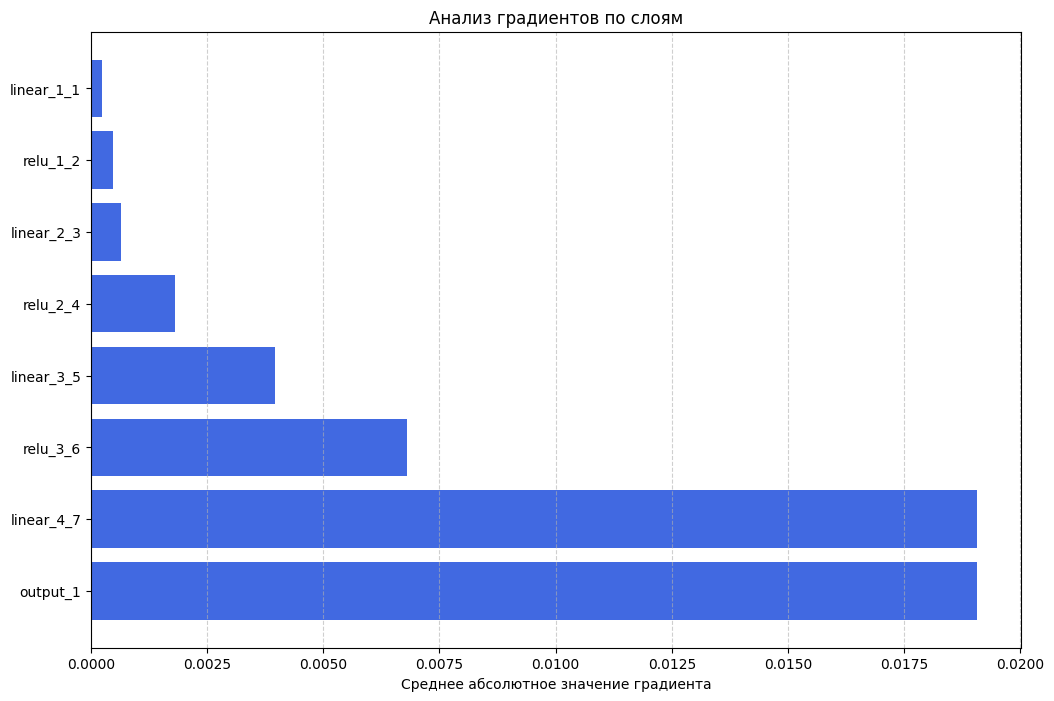

In [35]:
BATCH_SIZE = 16

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

x_batch, y_batch = next(iter(train_loader))


num_classes = len(torch.unique(full_dataset.target))

model = NestedSequentialModel(input_features=INPUT_FEATURES, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()


print("Структура модели")
model_history = tl.log_forward_pass(model, x_batch, vis_opt='unrolled', save_gradients=True)

outputs = model_history[-1].tensor_contents

loss = criterion(outputs, y_batch)
model.zero_grad()
loss.backward()

print("\n\n Промежуточные вычисления")
for layer_log in model_history:
    print(f"Выход слоя '{layer_log.layer_label}': {layer_log.tensor_contents.shape}")
    # print(layer_log.tensor_contents)

print("\n\n Градиенты")
grad_stats = {}
for layer_log in model_history:
    if layer_log.grad_contents is not None:
        print(f"Градиент для '{layer_log.layer_label}': {layer_log.grad_contents.shape}")
        grad_stats[layer_log.layer_label] = torch.mean(torch.abs(layer_log.grad_contents)).item()
    else:
        print(f"Градиент для '{layer_log.layer_label}': None")



if grad_stats:
    print('\n\n')
    labels = list(grad_stats.keys())
    values = list(grad_stats.values())
    plt.figure(figsize=(12, 8))
    plt.barh(labels, values, color='royalblue')
    plt.xlabel('Среднее абсолютное значение градиента')
    plt.title('Анализ градиентов по слоям')
    plt.gca().invert_yaxis() # Для лучшей читаемости, чтобы первый слой был сверху
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Нет доступных градиентов для визуализации. Убедитесь, что градиенты вычисляются.")

<p class="task" id="4"></p>

4\. Обучите созданную модель. Используя обученную модель и пакет `captum`, оцените важность признаков для каждого примера тестовой выборки, используя алгоритм `IntegratedGradients`. Визуализируйте полученные результаты, просуммировав по наблюдениям значения коэффициентов важности для каждого признака.

- [ ] Проверено на семинаре

In [36]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"{NUM_EPOCHS}")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{NUM_EPOCHS} (Обучение)"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Эпоха {epoch+1}, Потери на обучении: {running_loss/len(train_loader):.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Точность на тестовой выборке: {accuracy:.2f}%")

print("Обучение завершено.")

10


Эпоха 1/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 688.66it/s]


Эпоха 1, Потери на обучении: 0.8283
Точность на тестовой выборке: 61.95%


Эпоха 2/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 665.15it/s]


Эпоха 2, Потери на обучении: 0.7525
Точность на тестовой выборке: 63.10%


Эпоха 3/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 628.03it/s]


Эпоха 3, Потери на обучении: 0.5573
Точность на тестовой выборке: 78.00%


Эпоха 4/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 720.37it/s]


Эпоха 4, Потери на обучении: 0.4482
Точность на тестовой выборке: 73.00%


Эпоха 5/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 672.85it/s]


Эпоха 5, Потери на обучении: 0.4196
Точность на тестовой выборке: 83.55%


Эпоха 6/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 607.59it/s]


Эпоха 6, Потери на обучении: 0.4111
Точность на тестовой выборке: 83.75%


Эпоха 7/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 669.77it/s]


Эпоха 7, Потери на обучении: 0.3833
Точность на тестовой выборке: 85.15%


Эпоха 8/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 596.40it/s]


Эпоха 8, Потери на обучении: 0.3828
Точность на тестовой выборке: 85.15%


Эпоха 9/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 585.75it/s]


Эпоха 9, Потери на обучении: 0.3586
Точность на тестовой выборке: 84.15%


Эпоха 10/10 (Обучение): 100%|██████████| 500/500 [00:00<00:00, 618.72it/s]

Эпоха 10, Потери на обучении: 0.3590
Точность на тестовой выборке: 81.85%
Обучение завершено.


Расчет важности признаков с помощью IntegratedGradients...


Расчет attributions: 100%|██████████| 125/125 [00:01<00:00, 74.58it/s]
C:\Users\Rog G16\AppData\Local\Temp\ipykernel_28500\3296641448.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')



Визуализация важности признаков:


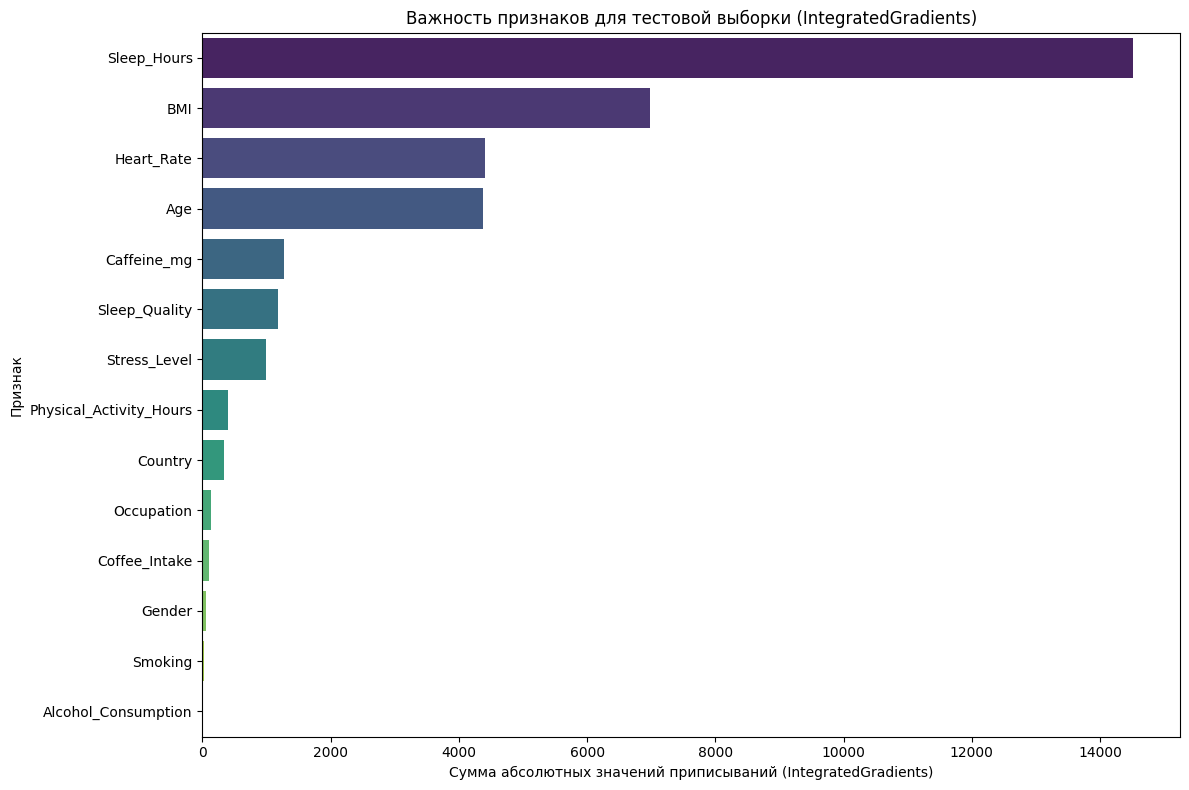

In [37]:
ig = IntegratedGradients(model)

all_attributions = []

print("Расчет важности признаков с помощью IntegratedGradients...")

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Расчет attributions"):
        outputs = model(inputs)
        _, predicted_classes = torch.max(outputs, 1)
        attributions = ig.attribute(inputs, target=predicted_classes, n_steps=50)
        all_attributions.append(attributions.cpu().numpy())

all_attributions = np.concatenate(all_attributions, axis=0)

feature_importance = np.sum(np.abs(all_attributions), axis=0)

feature_names = full_dataset.feature_names

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("\nВизуализация важности признаков:")

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков для тестовой выборки (IntegratedGradients)')
plt.xlabel('Сумма абсолютных значений приписываний (IntegratedGradients)')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

<p class="task" id="5"></p>

5\. Используя алгоритм `DeepExlainer` из пакета `shap`, рассчитайте shap-значения для одного случайно выбранного примера тестовой выборки. В качестве репрезентативного множества используйте набор из 50 случайных наблюдений обучающей выборки. Визуализируйте несколько стандартных графиков, которые позволяет строить пакет `shap`, и дайте текстовое описание к каждому из них.



- [ ] Проверено на семинаре

In [38]:
shap.initjs()


Force Plot




Waterfall Plot


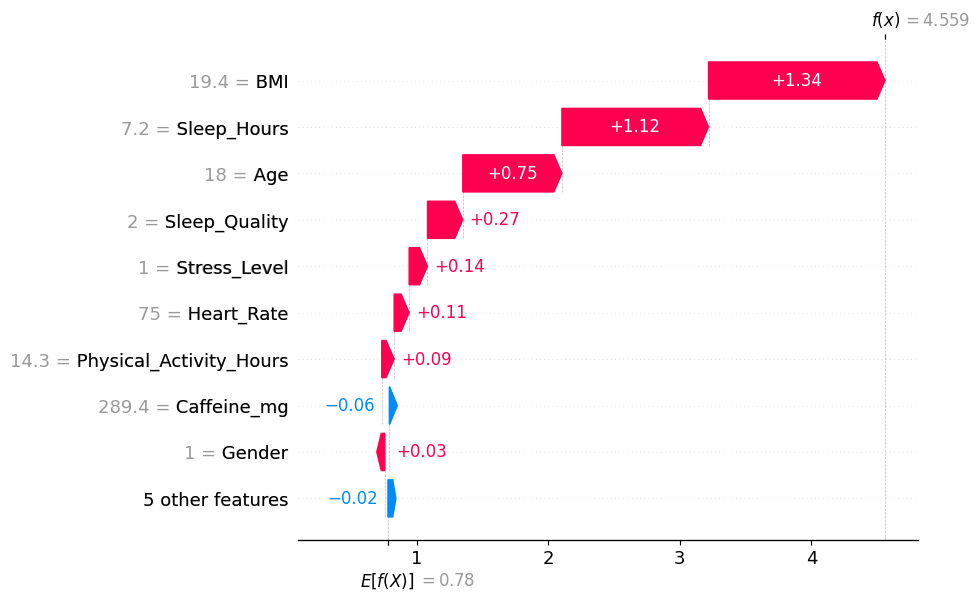



Summary Plot


C:\Users\Rog G16\AppData\Local\Temp\ipykernel_28500\664955312.py:54: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


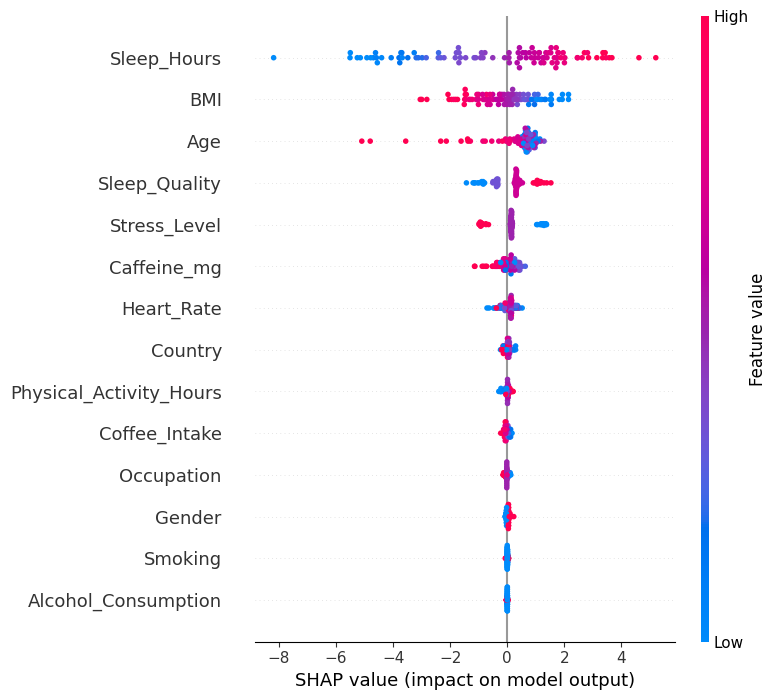



Summary Plot


C:\Users\Rog G16\AppData\Local\Temp\ipykernel_28500\664955312.py:62: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


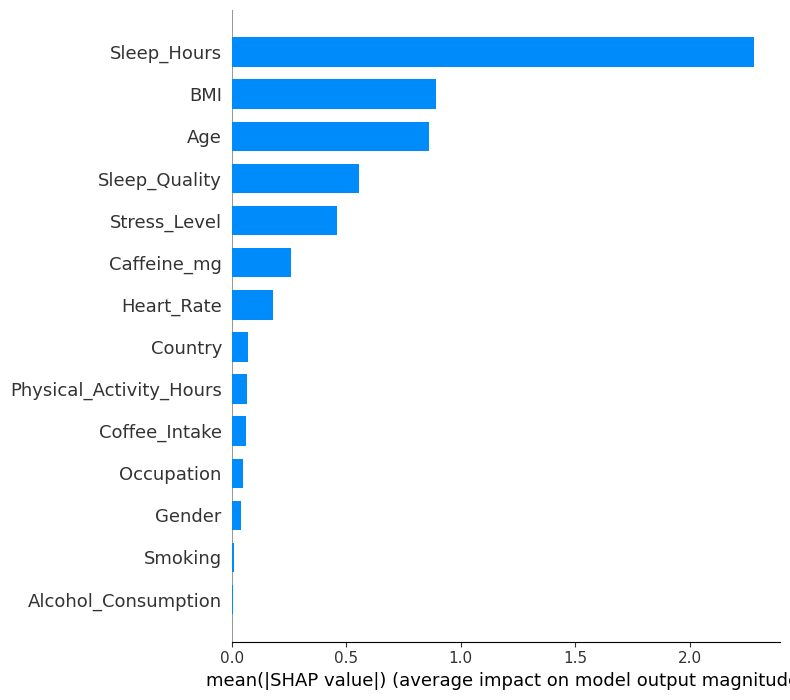

In [39]:
model.eval()

random_test_idx = np.random.randint(0, len(test_data))
x_test_sample, y_test_sample = test_data[random_test_idx]
x_test_sample_tensor = x_test_sample.unsqueeze(0) # Добавляем размерность батча

train_indices = np.random.choice(len(train_data), 50, replace=False)
background_data = torch.stack([train_data[i][0] for i in train_indices])

explainer = shap.DeepExplainer(model, background_data)

shap_values = explainer.shap_values(x_test_sample_tensor)

with torch.no_grad():
    output = model(x_test_sample_tensor)
    predicted_class = torch.argmax(output).item()

feature_names = full_dataset.feature_names


if isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim == 1:
    base_value_for_plot = explainer.expected_value[predicted_class]
else:
    print(f"Warning: explainer.expected_value has an unexpected type or shape: {type(explainer.expected_value)}, {np.shape(explainer.expected_value)}. Defaulting to 0.0")
    base_value_for_plot = 0.0


print("\nForce Plot")
shap.save_html("force_plot.html", shap.force_plot(
    base_value_for_plot, 
    shap_values[0,:, predicted_class],
    x_test_sample.cpu().numpy(),
    feature_names=feature_names
))
display(HTML('force_plot.html'))

print("\n\nWaterfall Plot")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0, :, predicted_class],
    base_values=base_value_for_plot,
    data=x_test_sample.cpu().numpy(),
    feature_names=feature_names
))


num_summary_samples = 100
sample_test_indices = np.random.choice(len(test_data), num_summary_samples, replace=False)
x_test_summary_samples = torch.stack([test_data[i][0] for i in sample_test_indices])

shap_values_summary = explainer.shap_values(x_test_summary_samples)


print("\n\nSummary Plot")
shap.summary_plot(
    shap_values_summary[:, :, predicted_class],
    x_test_summary_samples.cpu().numpy(),
    feature_names=feature_names,
)


print("\n\nSummary Plot")
shap.summary_plot(
    shap_values_summary[:, :, predicted_class],
    x_test_summary_samples.cpu().numpy(),
    feature_names=feature_names,
    plot_type="bar"
)